# Generating and Segmenting with Character-Level Transformer

In [12]:
import sys
sys.path.append('../../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datasets
from transformers import AutoTokenizer, AutoModelForCausalLM

from src.models.gpt2 import GPT2FeatureModel, GPT2LMHeadModel
from src.preprocessing import create_phoneme_map
from src.preprocessing import DataPreprocessor
from src.config import DataPreprocessingParams

phoible = pd.read_csv('../../data/phoible.csv')

/var/folders/nz/6tzh0bsj2txd1cz18gpcms_c0000gn/T/ipykernel_74402/481526044.py:6: DtypeWarning: Columns (4,7,8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  phoible = pd.read_csv('../../data/phoible.csv')


## Load model

In [18]:
tokenizer = AutoTokenizer.from_pretrained('transformersegmentation/CHILDES-Tokenizer')
phoneme_map = create_phoneme_map(tokenizer, '../../data/phoible.csv')
#model = GPT2FeatureModel.from_pretrained('transformersegmentation/GPT2-gpt2_feature_model-model', revision='english', feature_map=phoneme_map)
#model.return_token_logits = True
model = GPT2LMHeadModel.from_pretrained('transformersegmentation/grid-search-gpt2_lm_head_model-model', revision='English-02611')

/Users/zebulongoriely/Documents/UniDocs/PHD/research/projects/CharTransformers/TransformerSegmentation/analysis/segmentation/../../src/preprocessing.py:29: DtypeWarning: Columns (4,7,8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  phoible = pd.read_csv(phoible_data_path)


## Load corpus

In [30]:
dataset = datasets.load_dataset('transformersegmentation/CHILDES', 'English', split='valid', features = datasets.Features({'phonemized_utterance': datasets.Value("string")}))
dataset = dataset.rename_column('phonemized_utterance', 'text')
preprocessor = DataPreprocessor(DataPreprocessingParams(64, 'dynamic', subsample=1000, subsample_type='examples', remove_word_boundaries=True), tokenizer, get_word_boundaries=True)
dataset = dataset.map(preprocessor, batched=True)

In [35]:
tokenizer.convert_ids_to_tokens(dataset['input_ids'][0])

['d̠ʒ',
 'ʌ',
 's',
 't',
 'l',
 'aɪ',
 'k',
 'j',
 'ʊ',
 'ɹ',
 'b',
 'ʊ',
 'k',
 'æ',
 't',
 'h',
 'oʊ',
 'm']

## Generate Text

In [15]:
# Generate a sample
input_ids = tokenizer.encode('h', return_tensors='pt')
sample_outputs = model.generate(input_ids, do_sample=True, max_length=50, top_k=10, top_p=0.95, num_return_sequences=3, pad_token_id=tokenizer.pad_token_id)
for i, sample_output in enumerate(sample_outputs):
    print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))


0: h iː z ɐ n aɪ s UTT_BOUNDARY h ʌ UTT_BOUNDARY w aɪ d uː j uː n oʊ UTT_BOUNDARY ð ɛ ɹ z ð ə d ɑː ɡ i UTT_BOUNDARY n aʊ ð æ t s ɹ aɪ t UTT_BOUNDARY n oʊ ð æ t s p ɹ ɑː
1: h iː h ɐ z ɐ b ɹ ɛ d UTT_BOUNDARY w ɛ ɹ z ð ə b l æ k UTT_BOUNDARY d uː j uː n oʊ w ʌ t ð ɪ s ɪ z UTT_BOUNDARY n oʊ UTT_BOUNDARY oʊ k eɪ UTT_BOUNDARY w ɛ l aɪ k æ
2: h uː z s l iː p i b ɜː θ d eɪ p ɑː ɹ ɾ i ɪ n ð ɛ ɹ UTT_BOUNDARY j uː h ʌ UTT_BOUNDARY w ʌ t d uː j uː h æ v f ɹ ʌ m h ɪ ɹ UTT_BOUNDARY oʊ UTT_BOUNDARY ɪ


## Prediction Error

Plotting of prediction error from a model given a prompt.

In [17]:
from src.evaluation.segmentation import GPT2FeaturesSegmenter, GPT2Segmenter
segmenter = GPT2Segmenter(model, tokenizer, dataset['valid']['phonemized_utterance'], stride=1)
#segmenter = GPT2FeaturesSegmenter(model, tokenizer, dataset['train']['phonemized_utterance'][:3000], stride=0)

100%|██████████| 8958/8958 [07:23<00:00, 20.19it/s]


In [ ]:
from scipy.optimize import minimize_scalar

def plot_utterance(data, measures, cutoffs=None):
    """ Plots a single utterance against each measure in `data` to visualise segmentation. 
    Parameters
    ----------
    data : dict
        A processed utterance containing statistical and boundary information. See `process_utterance` method above.
    measures : sequence of str
        List of keys in `data` to plot.
    cutoffs : sequence of str, optional
        Cutoff values used for segmentation, plotted as horizontal lines on each plot.
    """
    _, axs = plt.subplots(len(measures),1, figsize=(20, 20))
    for i, ax in enumerate(axs):
        ax.plot('Pos', measures[i], data=data)
        ax.set_ylabel(measures[i])
        ax.set_xticks(data.Pos, data.Phoneme)

        cutoff = cutoffs[i] if cutoffs else None
        for j in range(len(ax.get_xticklabels())):
            tick = ax.get_xticklabels()[j]
            is_boundary = data.Starts[j]
            y_value = data[measures[i]].values[j]
            # Add vertical line at boundary
            if is_boundary:
                ax.axvline(x=j, color='grey', alpha=0.5)
            # Set tick to green if correct boundary according to cutoff
            if cutoff:
                tick.set_color('green' if (is_boundary and y_value >= cutoff) or (not is_boundary and y_value < cutoff) else 'red')

        # Add cutoff line   
        if cutoff:
            ax.axhline(y=cutoff, color='pink', alpha=0.5)

    ax.set_xlabel('Phonemes')
    plt.show()

def get_cutoff_data(segmenter, measure, cutoffs):
    """ Get results for a specific measure at different cutoffs. """
    all_results = []
    for cutoff in cutoffs:
        results = segmenter.evaluate_cutoff_segmentation(measure, cutoff)
        results['Cutoff'] = cutoff
        all_results.append(results)
    all_results = pd.concat(all_results)
    return all_results

def plot_scores_by_cutoff(results):
    """ Plot each measure against the different cutoffs used. Adds a vertical and horizontal line at the best value for each score. """
    num_columns = 3
    scores = sorted(list(set(results.keys()) - {'Cutoff'}))
    num_rows = len(results.keys()) // num_columns
    _, axs = plt.subplots(num_rows, num_columns, figsize=(20, 20))
    column = 0
    for i, score in enumerate(scores):
        graph = seaborn.lineplot(results, x='Cutoff', y=score, ax=axs[i//num_columns, column])
        max_score = results[results[score] == results[score].max()].head(1)
        max_cutoff = float(max_score['Cutoff'])
        max_score = float(max_score[score])
        graph.axvline(max_cutoff, color='grey', alpha=0.5)
        graph.axhline(max_score, color='pink', alpha=0.5)
        graph.set_ybound(0,1)
        column = (column + 1) % num_columns
    plt.show()

def plot_roc(results, measure1, measure2):
    """ Plot two scores against each other (e.g. precision against recall) """
    seaborn.lineplot(results, x=measure1, y=measure2)
    plt.show()

def plot_optimal_cutoff(segmenter, measure, score, cutoff):

    min, max = segmenter.processed_utterances[measure].min(), segmenter.processed_utterances[measure].max()
    cutoffs = np.linspace(min, max, 50)
    scores = [segmenter.evaluate_cutoff_segmentation(measure, cutoff)[score] for cutoff in cutoffs]
    graph = seaborn.lineplot(x=cutoffs, y=scores)
    graph.axvline(cutoff, color='grey', alpha=0.5)
    plt.show()

def summarise_segmentation(segmenter, measure='Entropy', score='type_fscore', cutoff=None, show_plots=False):
    spike_data = segmenter.evaluate_spike_segmentation(measure)
    print('Spike {}: {}'.format(score, round(spike_data[score]*100,2)))
    if cutoff:
        best_cutoff = cutoff
        best_result = segmenter.evaluate_cutoff_segmentation(measure, cutoff)[score]
    else:
        best_cutoff, best_result = segmenter.find_best_cutoff(measure, score)
        print('Best cutoff:', best_cutoff)
    print('Best {} at cutoff {}: {}'.format(score, best_cutoff, round(best_result*100, 2)))
    if show_plots:
        plot_optimal_cutoff(segmenter, measure, score, best_cutoff)


In [ ]:
all_measures = ['Entropy', 'Increase in Entropy', 'Boundary Prediction', 'Increase in Boundary Prediction', 'Loss', 'Increase in Loss', 'Rank', 'Increase in Rank']
all_measures = ['Entropy', 'Boundary Prediction', 'Loss', 'Rank']
best_cutoffs = {measure : segmenter.find_best_cutoff(measure, 'boundary_noedge_fscore')[0] for measure in all_measures}

print("Best cutoffs: ", best_cutoffs)

Best cutoffs:  {'Entropy': 2.104668322844612, 'Boundary Prediction': 0.0014540447080540894, 'Loss': 1.77869607941929, 'Rank': 1.2647505916335922}


In [ ]:
# segmenter.processed_utterances['Majority Vote Cutoff'] = 0
# segmenter.processed_utterances['Majority Vote Spike'] = 0
# for measure in all_measures:
#     segmenter.processed_utterances['Majority Vote Cutoff'] += (segmenter.processed_utterances[measure] >= best_cutoffs[measure]).astype(int)
#     shift_left = segmenter.processed_utterances[measure].shift(1)
#     shift_right = segmenter.processed_utterances[measure].shift(-1)
#     segmenter.processed_utterances['Majority Vote Spike'] += ((segmenter.processed_utterances[measure] > shift_left) & (segmenter.processed_utterances[measure] > shift_right)).astype(int)

segmenter.add_majority_vote(best_cutoffs)

best_cutoffs['Majority Vote Cutoff'] = 0.5
best_cutoffs['Majority Vote Spike'] = 0.5
all_measures += ['Majority Vote Cutoff', 'Majority Vote Spike']

In [ ]:
example_utterance = segmenter.processed_utterances.loc[0:64].copy()
example_utterance.Phoneme = example_utterance.Phoneme.apply(lambda x: x if x != 'UTT_BOUNDARY' else ' ')

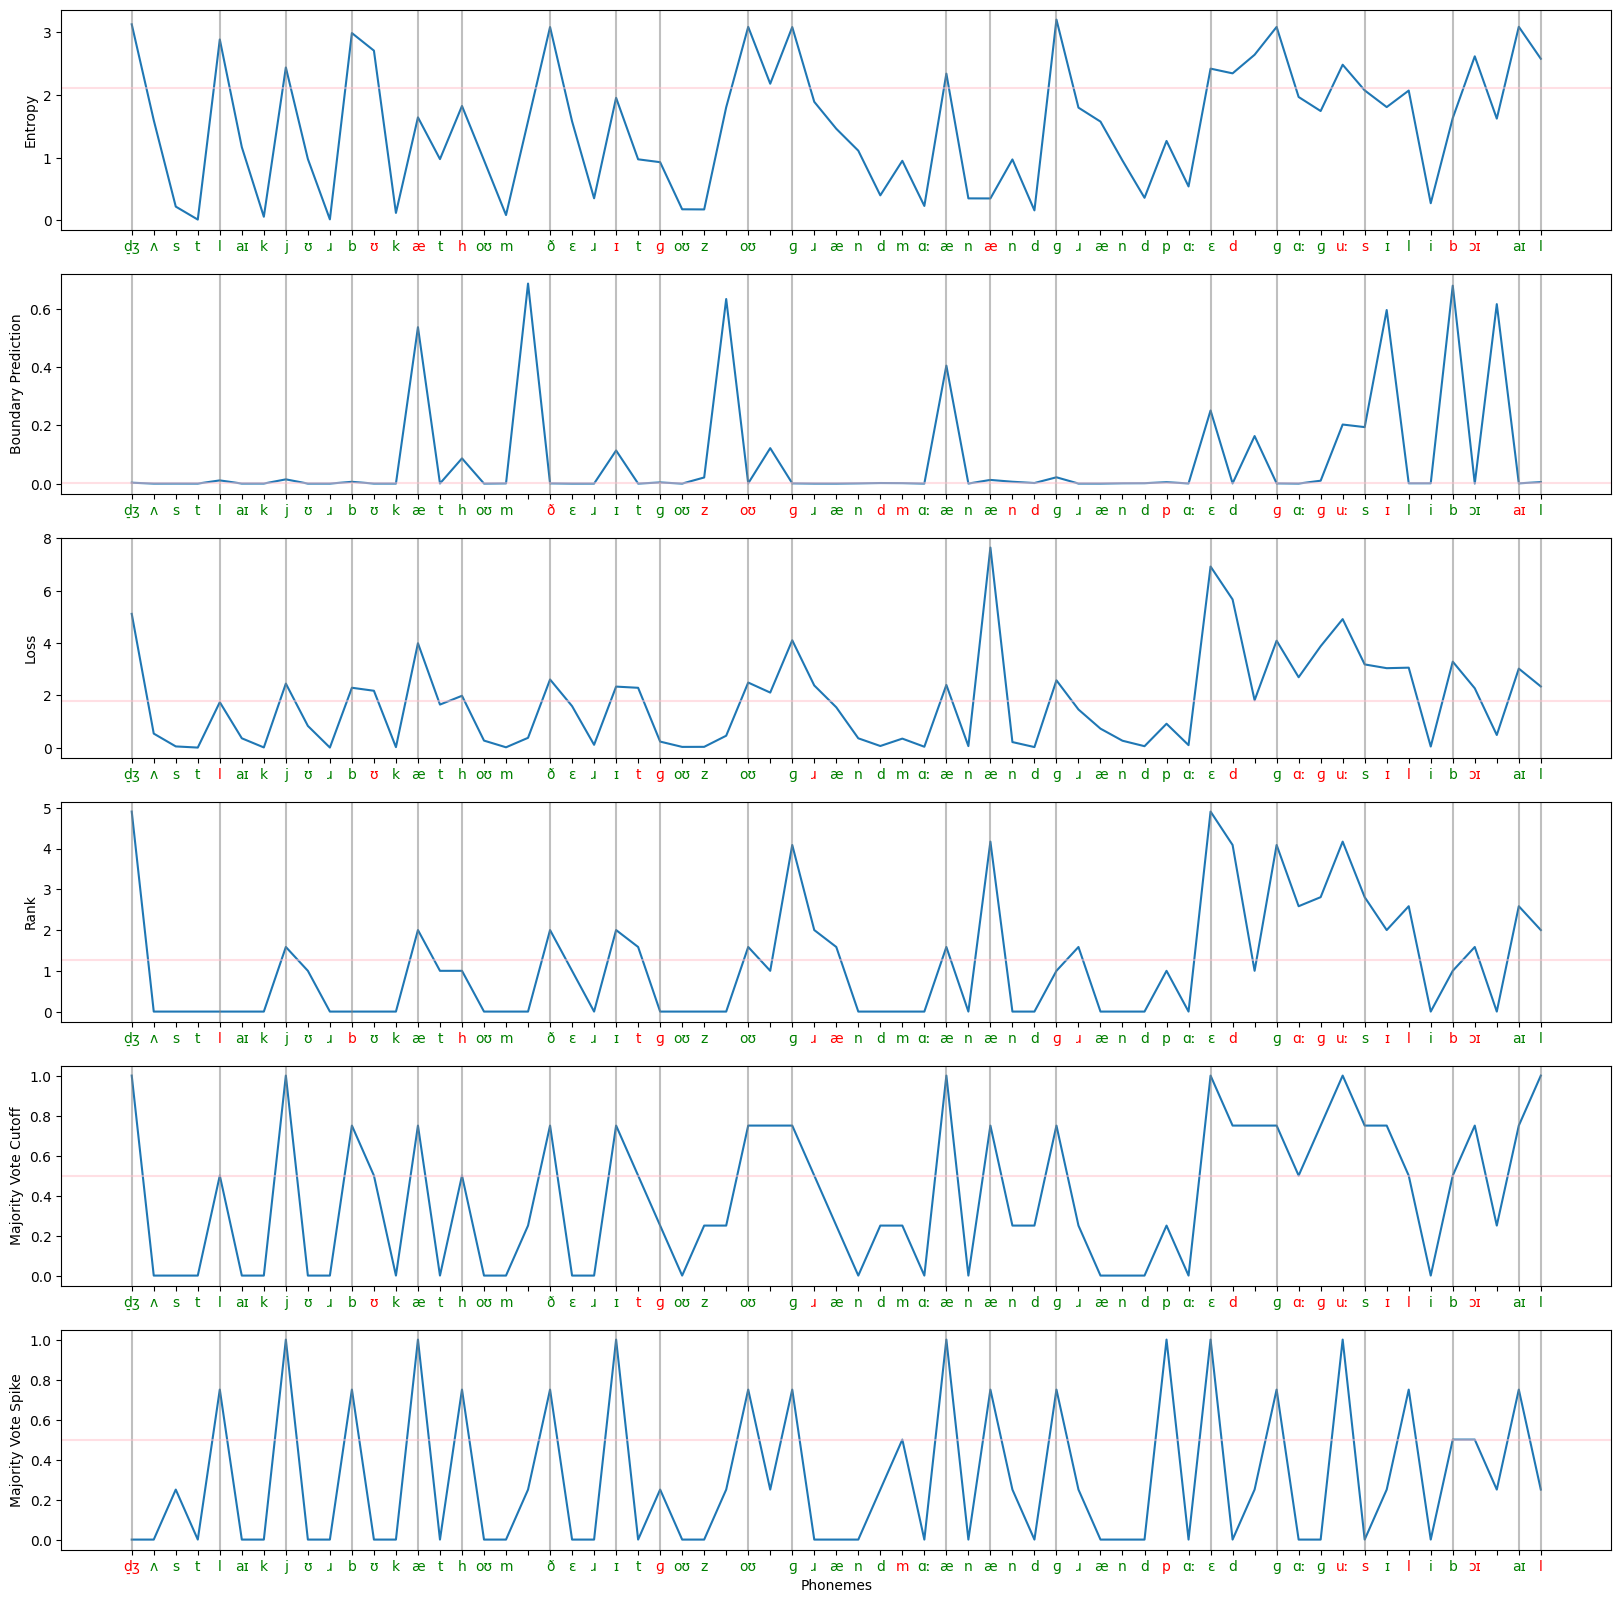

d̠ʒʌstlaɪkjʊɹbʊkæthoʊm ðɛɹɪtɡoʊz oʊ ɡɹændmɑːænændɡɹændpɑːɛd ɡɑːɡuːsɪlibɔɪ aɪl


In [ ]:
plot_utterance(example_utterance, list(best_cutoffs.keys()), list(best_cutoffs.values()))
#plot_utterance(data, ['Feature Loss', 'Feature Entropy', 'Loss Deviation', 'Boundary Feature Prediction'], [0.01, 0.3, 0.01, 0.5])
print(''.join(list(example_utterance.Phoneme)))

In [ ]:
for measure in all_measures:
    print('\n' + measure)
    summarise_segmentation(segmenter, measure, 'type_fscore', best_cutoffs[measure], show_plots=True)
#for measure in ['Feature Loss', 'Increase in Feature Loss', 'Feature Entropy', 'Increase in Feature Entropy', 'Loss Deviation', 'Increase in Loss Deviation', 'Boundary Feature Prediction', 'Increase in Boundary Feature Prediction']:

NameError: name 'all_measures' is not defined

In [ ]:
for measure in all_measures:
    print('\n' + measure)
    summarise_segmentation(segmenter, measure, 'type_fscore', show_plots=True)

NameError: name 'all_measures' is not defined

In [ ]:
summarise_segmentation(segmenter, 'Majority Vote Cutoff', 'boundary_noedge_fscore', show_plots=True, cutoff=best_cutoffs['Majority Vote Cutoff'])
summarise_segmentation(segmenter, 'Majority Vote Spike', 'boundary_noedge_fscore', show_plots=True, cutoff=best_cutoffs['Majority Vote Spike'])

NameError: name 'summarise_segmentation' is not defined

In [ ]:
summarise_segmentation(segmenter, 'Majority Vote Cutoff', 'boundary_noedge_fscore', show_plots=True)
summarise_segmentation(segmenter, 'Majority Vote Spike', 'boundary_noedge_fscore', show_plots=True)

NameError: name 'summarise_segmentation' is not defined